In [1]:
import locale
# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scienceplots
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

plt.rcParams['axes.formatter.use_locale'] = True

# use fancy style and tex in plt
plt.style.use(['science', 'russian-font'])
matplotlib.rc('text', usetex = True)
preamble = plt.rcParams.get('text.latex.preamble')
params = {
  'pgf.rcfonts' : False,
  'pgf.texsystem' : 'pdflatex',
  'pgf.preamble' : "\n".join([preamble,r'\usepackage{textcomp,mathcomp}'])

}
plt.rcParams.update(params)
plt.rcParams.update({"axes.grid" : True, "grid.linestyle" : (0, (5, 10))})

np.random.seed(0)

import os
current_dir = os.getcwd().lower()

OUTPUT_DIR = 'processor_output'
# Create output folder if it does not exist
if (not os.path.exists(f'./{OUTPUT_DIR}')):
    os.makedirs(OUTPUT_DIR)

In [92]:
RHO = 13.52
G = 9.8
R = 8.31
MU = 0.046

HEIGHT_ERR = 0.4

In [25]:
df = pd.read_csv('data.csv')

In [26]:
import itertools
import math
def gen_bars(df, col, err):
  df = df.copy()
  df[col+'_hb'] = df[col] + err
  df[col+'_lb'] = df[col] - err
  return df

def gen_col_with_bars(df, col, func, *params):
  lb = pd.Series([math.inf] * len(df), index=df.index)
  hb = pd.Series([-math.inf] * len(df), index=df.index)
  for i in itertools.product(*[[col+'_hb', col+'_lb'] for col in params]):
    val = df.apply(lambda x: func(**{key[:-3]: x[key] for key in i}), axis=1)
    lb = np.minimum(lb, val)
    hb = np.maximum(hb, val)
  df = df.copy()
  df[col] = df.apply(lambda x: func(**{key: x[key] for key in params}), axis=1)
  df[col+'_hb'] = hb
  df[col+'_lb'] = lb
  return df

In [30]:
def get_press(height):
  return height * RHO * G

df = gen_bars(df, 'height', HEIGHT_ERR)
df = gen_bars(df, 'temp', 0.2)
df = gen_col_with_bars(df, 'press', get_press, 'height')
df = gen_col_with_bars(df, 'lnpress', lambda press: np.log(press), 'press')
df = gen_col_with_bars(df, 'invtemp', lambda temp: 1 / (temp + 273), 'temp')

In [78]:
def to_rus_str(col):
  return col.astype('str').str.replace('.', ',')

def gen_latex_col(df, col, round, err=None, mult=1):
  if round > 0:
    fround = lambda x: x.round(round)
  else:
    fround = lambda x: x.astype(int)

  if err is None:
    err = (df[col+'_hb'] - df[col+'_lb']) / 2
  err = to_rus_str(fround(err) * mult)
  newcol = to_rus_str(fround(df[col]) * mult)
  return "$" + newcol + " \pm " + err + "$"

In [59]:
def gen_meas_tbl(df, index):
  columns = [
      r'$T$, \textcelsius',
      r'$\Delta h$, мм',
      r'$P$, Па',
      r'$\ln P$',
      r'$T^{-1}$, $К^{-1}$'
    ]

  new = pd.concat(
    [
      df['temp'],
      df['height'].round(1),
      df['press'].round(-1).astype(int),
      df['lnpress'].round(3),
      df['invtemp'].round(6)
    ], axis=1)
  new = new.apply(to_rus_str, axis=0)
  new.columns = columns
  return new.to_latex(index_names=False,
                      index=False,
                      buf=f'{OUTPUT_DIR}/tbl_meas_{index}.tex',
                      column_format='ccccc',
                      multicolumn_format='c',
                      decimal=',')

gen_meas_tbl(df[df.heating == 0].sort_values('temp'), 'cooling')
gen_meas_tbl(df[df.heating == 1].sort_values('temp'), 'heating')

In [40]:
def get_err_from_bars(df, col):
  return (df[col+'_hb'] - df[col+'_lb']) / 2

def get_errs(df, col):
  return np.vstack((df[col+'_hb'] - df[col],  df[col] - df[col+'_lb']))

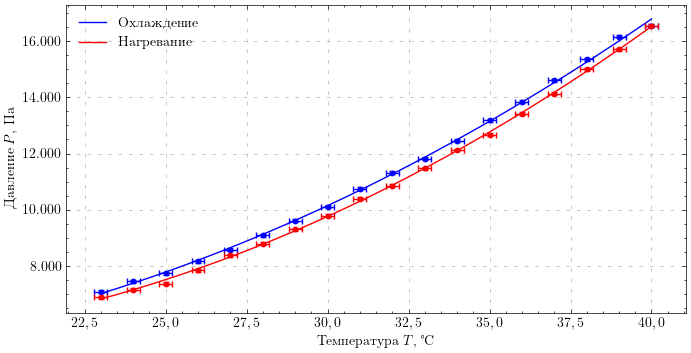

In [53]:
def plot_temp_press(ax, df, label, color):
  y = df.press
  x = df.temp
  yerr = get_errs(df, 'press')
  xerr = get_errs(df, 'temp')

  p = np.poly1d(np.polyfit(x, y, 2))

  xp = np.linspace(x.min(), x.max(), 100)

  sc, = ax.plot(xp, p(xp), label=label, c=color)
  ax.scatter(x, y, s=10, zorder=10, c=sc.get_color())
  ax.errorbar(x, y, yerr=yerr, xerr=xerr, ls='None', ecolor=sc.get_color(),
              capsize=2, c=sc.get_color())

fig, ax = plt.subplots(figsize=(8, 4))
plot_temp_press(ax, df[df.heating == 0].sort_values('temp'), 'Охлаждение', 'blue')
plot_temp_press(ax, df[df.heating == 1].sort_values('temp'), 'Нагревание', 'red')
plt.ylabel(f'Давление $P$, Па')
plt.xlabel(f'Температура $T$, \\textcelsius')
plt.legend()
plt.savefig(f'{OUTPUT_DIR}/temp_press.pgf')

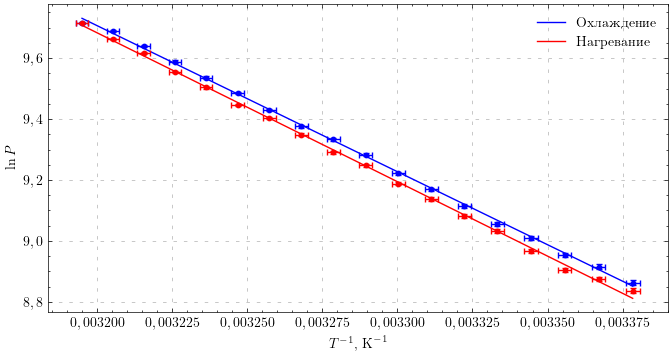

In [58]:
def plot_invtemp_lnpress(ax, df, label, color):
  y = df.lnpress
  x = df.invtemp
  yerr = get_errs(df, 'lnpress')
  xerr = get_errs(df, 'invtemp')

  p = np.poly1d(np.polyfit(x, y, 1))

  xp = np.linspace(x.min(), x.max(), 100)

  sc, = ax.plot(xp, p(xp), label=label, c=color)
  ax.scatter(x, y, s=10, zorder=10, c=sc.get_color())
  ax.errorbar(x, y, yerr=yerr, xerr=xerr, ls='None', ecolor=sc.get_color(),
              capsize=2, c=sc.get_color())

fig, ax = plt.subplots(figsize=(8, 4))
plot_invtemp_lnpress(ax, df[df.heating == 0].sort_values('temp'), 'Охлаждение', 'blue')
plot_invtemp_lnpress(ax, df[df.heating == 1].sort_values('temp'), 'Нагревание', 'red')
plt.ylabel(r'$\ln P$')
plt.xlabel(r'$T^{-1}$, $\text{К}^{-1}$')
plt.legend()
plt.savefig(f'{OUTPUT_DIR}/invtemp_lnpress.pgf')

In [62]:
def get_err_from_bars(df, col):
  return (df[col+'_hb'] - df[col+'_lb']) / 2

def get_random_sample(df, column, err=None):
  if err is None:
    return np.random.normal(df[column], (df[column+'_hb'] - df[column+'_lb']) / 2)
  else:
    return np.random.normal(df[column], err)

def simulate(df, xcol, ycol, num=1000, xerr=None, yerr=None):
  np.random.seed(0)
  slopes = []
  intercepts = []
  for i in range(num):
    x = get_random_sample(df, xcol, err=xerr)
    y = get_random_sample(df, ycol, err=yerr)

    coef = np.polyfit(x, y, 1)
    slopes.append(coef[0])
    intercepts.append(coef[1])

  return np.array(slopes), np.array(intercepts)

def get_slopes_stat(df, xcol, ycol):
  slopes, _ = simulate(df, xcol, ycol)
  return {'mean': np.mean(slopes), 'std': np.std(slopes)}

def get_sim_stat(df, xcol, ycol, xerr=None, yerr=None):
  slopes, intercepts = simulate(df, xcol, ycol, xerr=xerr, yerr=yerr)
  return {
    'slopes': {'mean': np.mean(slopes), 'std': np.std(slopes)},
    'intercepts': {'mean': np.mean(intercepts), 'std': np.std(intercepts)}
  }

{'mean': -4829.1147576469475, 'std': 34.85530273821731}

In [94]:
def get_lconst(df):
  slope = get_slopes_stat(df, 'invtemp', 'lnpress')
  lconst = -R / MU * slope['mean']
  lconst_err = abs(-R / MU * slope['std'])
  return (lconst, lconst_err)

lconst_cooling = get_lconst(df[df.heating == 0])
lconst_heating = get_lconst(df[df.heating == 1])
lconst = pd.DataFrame({'lconst': [lconst_cooling[0], lconst_heating[0]],
                       'lconst_err': [lconst_cooling[1], lconst_heating[1]]},
                      index=['cooling', 'heating'])
lconst

,lconst,lconst_err
cooling,863881.583085,8927.036184
heating,880428.001705,9294.289377


In [95]:
lconst = lconst.round(-3).astype(int)
lconst

,lconst,lconst_err
cooling,864000,9000
heating,880000,9000


In [98]:
def gen_lconst_tbl(df):
  columns = [
      r'',
      r'$L$, $\tfrac{кДж}{кг}$',
    ]

  new = pd.concat(
    [
      pd.Series(['Охлаждение', 'Нагрев'], index=df.index),
      gen_latex_col(df, 'lconst', 0, df['lconst_err'], 0.001)
    ], axis=1)
  new = new.apply(to_rus_str, axis=0)
  new.columns = columns
  return new.to_latex(index_names=False,
                      index=False,
                      buf=f'{OUTPUT_DIR}/tbl_lconst.tex',
                      column_format='c' * len(columns),
                      multicolumn_format='c',
                      decimal=',')

gen_lconst_tbl(lconst)

In [102]:
lconst['lconst'] / 930000 - 1

cooling   -0.070968
heating   -0.053763
Name: lconst, dtype: float64